# Basic data analysis - Spectral Unmixing, KMeans, PCA, NFINDR etc.

R. K. Vasudevan<sup>1,2</sup>, S. Somnath<sup>3</sup>

* <sup>1</sup>Center for Nanophase Materials Sciences
* <sup>2</sup>Institute for Functional Imaging of Materials 
* <sup>3</sup>Advanced Data and Workflows Group

Oak Ridge National Laboratory, Oak Ridge TN 37831, USA

#### In this notebook we load some spectral data, and perform basic data analysis, including:
* KMeans Clustering
* Non-negative Matrix Factorization
* Principal Component Analysis
* NFINDR

## Software Prerequisites:
* Standard distribution of ___Anaconda__ (includes numpy, scipy, matplotlib and sci-kit learn)
* __pysptools__ (will automatically be installed in the next step)
* __cvxopt__ for fully constrained least squares fitting
    * install in a terminal via __`conda install -c https://conda.anaconda.org/omnia cvxopt`__
* __pycroscopy__ : Though pycroscopy is mainly used here for plotting purposes only, it's true capabilities are realized through the ability to seamlessly perform these analyses on any imaging dataset (regardless of origin, size, complexity) and storing the results back into the same dataset among other things

In [1]:
# Installing sotware prerequisites via the python package index:
!pip install -U numpy matplotlib sklearn pysptools wget

#Import packages

# Ensure that this code works on both python 2 and python 3
from __future__ import division, print_function, absolute_import, unicode_literals

# basic numeric computation:
import numpy as np

# Plotting and visualization:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# for downloading files:
import wget
from os import remove

# multivariate analysis:
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from pysptools import eea
import pysptools.abundance_maps as amp
from pysptools.eea import nfindr

# finally import pycroscopy:
import pycroscopy as px

# configure the notebook to place plots after code cells within the notebook:
%matplotlib inline

Requirement already up-to-date: numpy in /Users/syz/anaconda/lib/python3.5/site-packages
Requirement already up-to-date: matplotlib in /Users/syz/anaconda/lib/python3.5/site-packages
Requirement already up-to-date: sklearn in /Users/syz/anaconda/lib/python3.5/site-packages
Requirement already up-to-date: pysptools in /Users/syz/anaconda/lib/python3.5/site-packages
Requirement already up-to-date: wget in /Users/syz/anaconda/lib/python3.5/site-packages
Requirement already up-to-date: python-dateutil in /Users/syz/anaconda/lib/python3.5/site-packages (from matplotlib)
Requirement already up-to-date: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=1.5.6 in /Users/syz/anaconda/lib/python3.5/site-packages (from matplotlib)
Requirement already up-to-date: cycler>=0.10 in /Users/syz/anaconda/lib/python3.5/site-packages (from matplotlib)
Requirement already up-to-date: six>=1.10 in /Users/syz/anaconda/lib/python3.5/site-packages (from matplotlib)
Requirement already up-to-date: pytz in /Users/syz/anaconda/l

## The Data

In this example, we will work on __Infrared (IR) Spectra__ data obtained from an Anasys Instruments Nano IR as one of the simplest examples of data. This dataset contains a single IR spectra collected at each position on a single line of spatial points. Thus, this two dimensional dataset has one position dimension (lets say X) and one spectral dimension (wavelength). 

In the event that the spectra were collected on a 2D grid of spatial locations (two spatial dimensions - X, Y), the resultant three dimensional dataset (X, Y, wavelength) would need to be reshaped to a two dimensional dataset of (position, wavelength) since this is the standard format that is accepted by all statistical analysis, machine learning, spectral unmixing algorithms. The same reshaping of data would need to be performed if there are more than two spectroscopic dimensions.

#### Working with the specific Nano IR dataset:
We will begin by downloading the data file from Github, followed by reshaping and decimation of the dataset

In [2]:
# download the data file from Github:
url = 'https://raw.githubusercontent.com/pycroscopy/pycroscopy/master/data/NanoIR.txt'
data_file_path = 'temp.txt'
_ = wget.download(url, data_file_path)
#data_file_path = px.io.uiGetFile(filter='Anasys NanoIR text export (*.txt)')

# Load the data from file to memory
data_mat = np.loadtxt(data_file_path, delimiter ='\t', skiprows =1 )
print('Data currently of shape:', data_mat.shape)

# Only every fifth column is of interest (position)
data_mat =  data_mat[:, 1::5]

# The data is structured as [wavelength, position]

# nans cannot be handled in most of these decompositions. So set them to be zero.
data_mat[np.isnan(data_mat)]=0 

# Finally, taking the transpose of the matrix to match [position, wavelength]
data_mat = data_mat.T

num_pos = data_mat.shape[0]
spec_pts = data_mat.shape[1]
print('Data currently of shape:', data_mat.shape)

x_label = 'Spectral dimension'
y_label = 'Intensity (a.u.)'

Data currently of shape: (451, 250)
Data currently of shape: (50, 451)


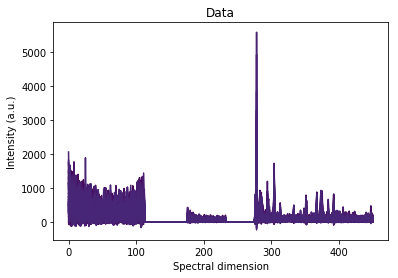

In [3]:
## Basic Visualization
fig, ax = plt.subplots()
colors = plt.cm.get_cmap('viridis', spec_pts)
for line_ind in range(num_pos):
    ax.plot(data_mat[line_ind], '-', color = colors(line_ind))
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_title('Data')

## 1. Singular Value Decomposition (SVD)

SVD is an eigenvector decomposition that is defined statistically, and therefore typically produces non-physical eigenvectors. Consequently, the interpretation of eigenvectors and abundance maps from SVD requires care and caution in interpretation. Nontheless, it is a good method for quickly visualizing the major trends in the dataset since the resultant eigenvectors are sorted in descending order of variance or importance. Furthermore, SVD is also very well suited for data cleaning through the reconstruction of the dataset using only the first N (most significant) components. 

SVD results in three matrices:
* V - Eigenvectors sorted by variance in descending order
* U - corresponding bundance maps
* S - Variance or importance of each of these components

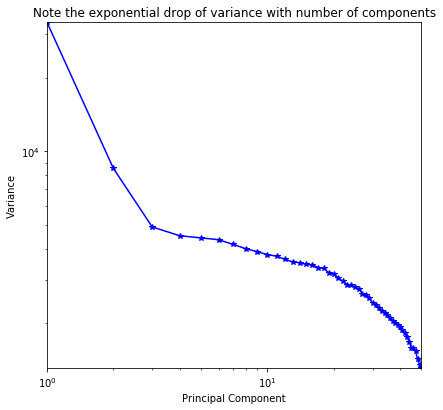

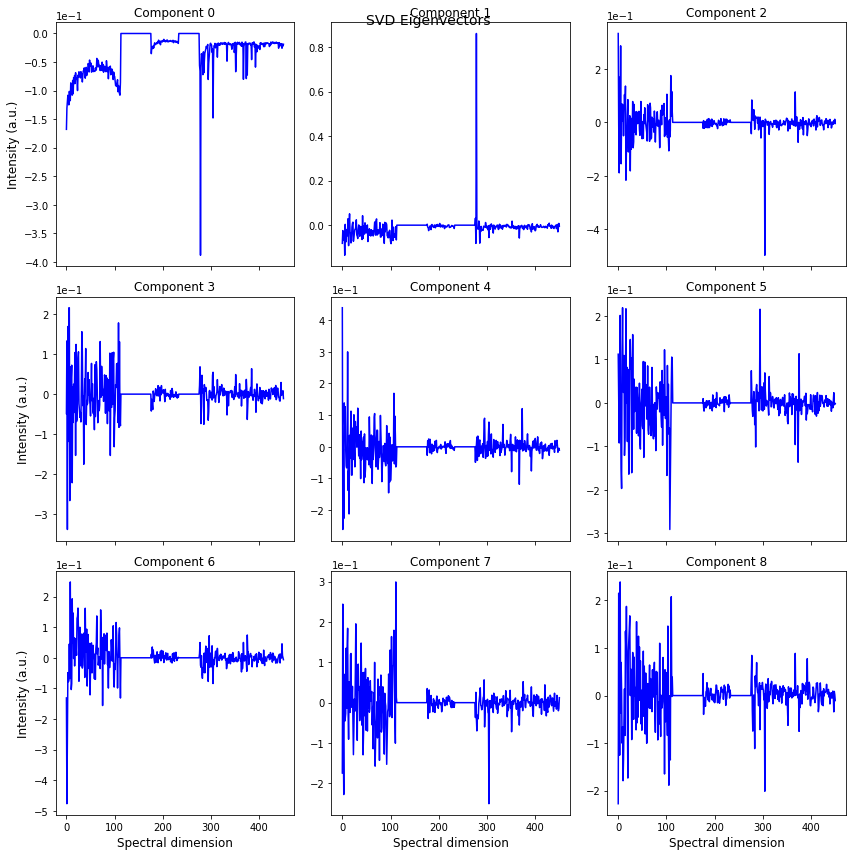

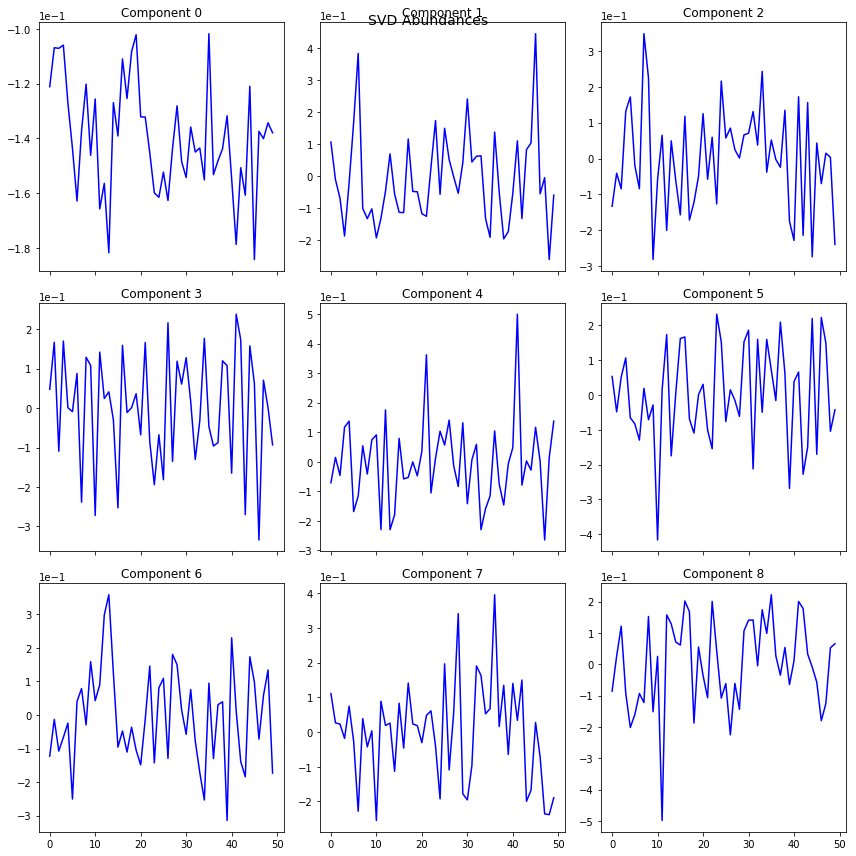

In [4]:
U, S, V = np.linalg.svd(data_mat, full_matrices = False, compute_uv = True)

# Visualize the variance / statistical importance of each component:
px.plot_utils.plotScree(S, title='Note the exponential drop of variance with number of components')

# Visualize the eigenvectors:
px.plot_utils.plot_loops(np.arange(spec_pts), V, x_label=x_label, y_label=y_label, plots_on_side=3, 
                         subtitles='Component', title='SVD Eigenvectors', evenly_spaced=False);

# Visualize the abundance maps:
px.plot_utils.plot_loops(np.arange(num_pos), U.T, plots_on_side=3, 
                         subtitles='Component', title='SVD Abundances', evenly_spaced=False);

## 2. KMeans Clustering

KMeans clustering is a quick and easy method to determine the types of spectral responses present in the data. It is not a decomposition method, but a basic clustering method. The user inputs the number of clusters (sets) to partition the data into. The algorithm proceeds to find the optimal labeling (ie., assignment of each spectra as belonging to the k<sup>th</sup> set) such that the within-cluster sum of squares is minimized.

Set the number of clusters below

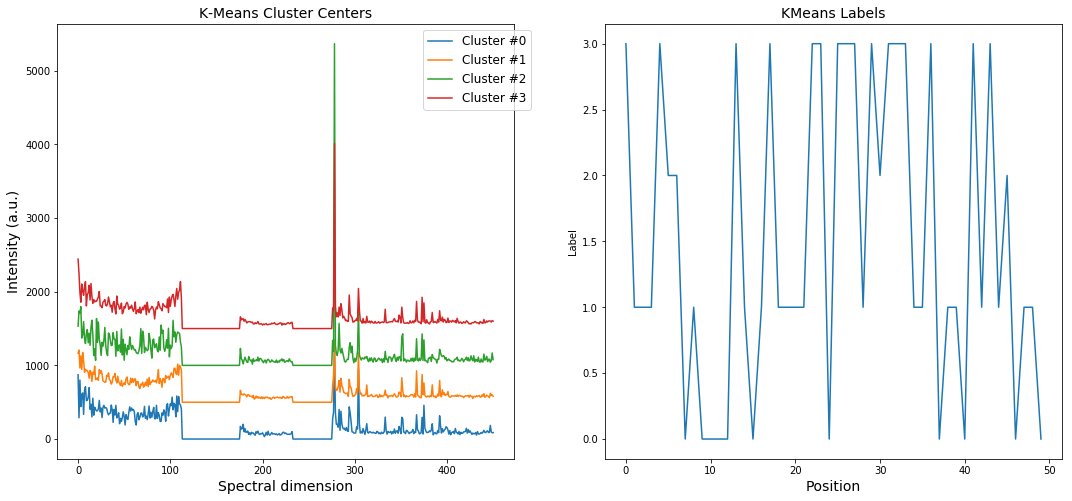

In [5]:
num_comps = 4

estimators = KMeans(num_comps)
results = estimators.fit(data_mat)

fig, axes = plt.subplots(ncols=2,figsize=(18,8))
for clust_ind, end_member in enumerate(results.cluster_centers_):
    axes[0].plot(end_member+(500*clust_ind), label = 'Cluster #' + str(clust_ind))
axes[0].legend(bbox_to_anchor = [1.05,1.0], fontsize=12)
axes[0].set_title('K-Means Cluster Centers', fontsize=14)
axes[0].set_xlabel(x_label, fontsize=14)
axes[0].set_ylabel(y_label, fontsize=14)

axes[1].plot(results.labels_)
axes[1].set_title('KMeans Labels', fontsize=14)
axes[1].set_xlabel('Position', fontsize=14)
axes[1].set_ylabel('Label');

## 3. Non-negative Maxtrix Factorization (NMF)

NMF, or non-negative matrix factorization, is a method that is useful towards unmixing of spectral data. It only works on data with positive real values. It operates by approximate determination of factors (matrices) W and H, given a matrix V, as shown below

![NMF](https://upload.wikimedia.org/wikipedia/commons/f/f9/NMF.png)

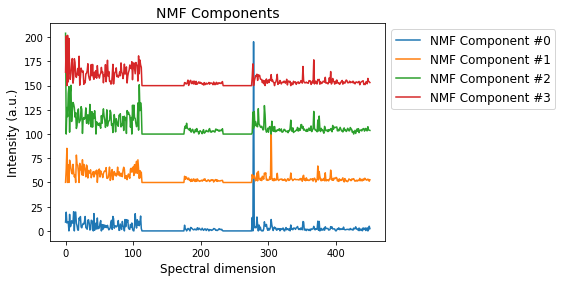

In [6]:
num_comps = 4

# Make sure the data is non-negative:
data_mat[data_mat < 0] = 0 

model = NMF(n_components=num_comps, init='random', random_state=0)
model.fit(data_mat) 

fig, axis = plt.subplots()
for comp_ind, end_member in enumerate(model.components_):
    axis.plot(end_member + comp_ind * 50, 
              label = 'NMF Component #' + str(comp_ind))
axis.set_xlabel(x_label, fontsize=12)
axis.set_ylabel(y_label, fontsize=12)
axis.set_title('NMF Components', fontsize=14)
axis.legend(bbox_to_anchor=[1.0,1.0], fontsize=12);

## 4. NFINDR

NFINDR is a geometric decomposition technique that can aid in determination of constitent spectra in data. The basic idea is as follows. Assume that at any point <i>x</i>, the spectra measured <i>A(w,x)</i> is a linear superposition of <i>k</i> 'pure' spectra, i.e.

<i>A(w,x)</i> = c<sub>0</sub>(x)a<sub>0</sub> + c<sub>1</sub>(x)a<sub>1</sub> + ... + c<sub>k</sub>(x)a<sub>k</sub>

In this case, our task consists of first determining the pure spectra {a<sub>0</sub>,...,a<sub>k</sub>}, and then determining the coefficients {c<sub>0</sub>,...,c<sub>k</sub>}. NFINDR determines the 'pure' spectra by first projecting the data into a low-dimensional sub-space (typically using PCA), and then taking the convex hull of the points in this space. Then, points are picked at random along the convex hull and the volume of the simplex that the points form is determined. If (k+1) pure spectra are needed, the data is reduced to (k) dimensions for this purpose. The points that maximize the volume of the simples are taken as the most representative pure spectra available in the dataset. One way to think of this is that any spectra that lie within the given volume can be represented as a superposition of these constituent spectra; thus maximizing this volume allows the purest spectra to be determined. 

The second task is to determine the coefficients. This is done usign the fully constrained least squares optimization, and involves the sum-to-one constraint, to allow quantitative comparisons to be made. More information can be found in the paper below:

[Winter, Michael E. "N-FINDR: An algorithm for fast autonomous spectral end-member determination in hyperspectral data." SPIE's International Symposium on Optical Science, Engineering, and Instrumentation. International Society for Optics and Photonics, 1999.](http://proceedings.spiedigitallibrary.org/proceeding.aspx?articleid=994814)

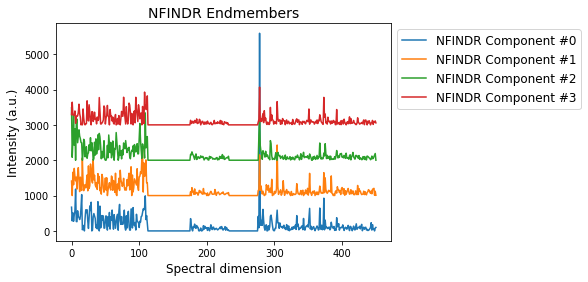

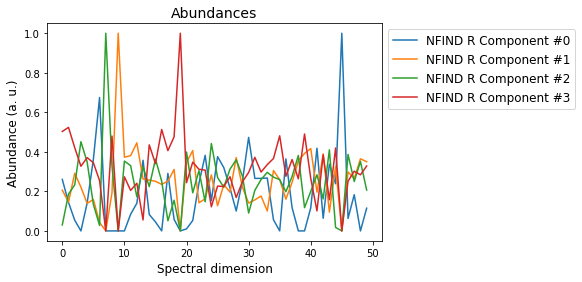

In [7]:
num_comps = 4

nfindr_results = eea.nfindr.NFINDR(data_mat, num_comps) #Find endmembers
end_members = nfindr_results[0]

fig, axis = plt.subplots()
for comp_ind, end_member in enumerate(end_members):
    axis.plot(end_member + comp_ind * 1000, 
              label = 'NFINDR Component #' + str(comp_ind))
axis.set_title('NFINDR Endmembers', fontsize=14)
axis.set_xlabel(x_label, fontsize=12)
axis.set_ylabel(y_label, fontsize=12)
axis.legend(bbox_to_anchor=[1.0,1.0], fontsize=12)

# fully constrained least squares model:
fcls = amp.FCLS() 
# Find abundances:
amap = fcls.map(data_mat[np.newaxis, :, :], end_members) 

# Reshaping amap to match those of conventional endmembers
amap = np.squeeze(amap).T

fig2, axis2 = plt.subplots()
for comp_ind, abundance in enumerate(amap):
    axis2.plot(abundance, label = 'NFIND R Component #' + str(comp_ind) )
axis2.set_title('Abundances', fontsize=14)
axis2.set_xlabel(x_label, fontsize=12)
axis2.set_ylabel('Abundance (a. u.)', fontsize=12)
axis2.legend(bbox_to_anchor=[1.0,1.0], fontsize=12);

In [ ]:
# Delete the temporarily downloaded file
remove(data_file_path)